In [40]:
import os
import sys
import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [41]:
def load_data(image_dir, image_size):
    """
    Loads all cleaned images from the directory and extracts labels
    from the filenames.
    """
    print(f"Loading images from: {image_dir}")
    images = []
    labels = []
    
    if not os.path.exists(image_dir):
        print(f"Error: Directory not found: '{image_dir}'", file=sys.stderr)
        print("Please run the 'clean_images.py' script first.", file=sys.stderr)
        sys.exit(1)
        
    for filename in os.listdir(image_dir):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        # Extract label from filename (e.g., "dandelion_...")
        try:
            label = filename.split('_')[0]
        except IndexError:
            print(f"Warning: Skipping file with unusual name: {filename}")
            continue
            
        # Load the image
        try:
            img_path = os.path.join(image_dir, filename)
            with Image.open(img_path) as img:
                # Ensure it's the correct size (should be already, but good check)
                if img.size != image_size:
                    img = img.resize(image_size)
                
                # Convert to numpy array and normalize
                img_array = np.asarray(img) / 255.0
                
                images.append(img_array)
                labels.append(label)
                
        except (IOError, UnidentifiedImageError, OSError) as e:
            print(f"Warning: Skipping corrupt image {filename}: {e}")
            
    if not images:
        print("Error: No images were successfully loaded.", file=sys.stderr)
        sys.exit(1)

    print(f"Successfully loaded {len(images)} images.")
    return np.array(images), np.array(labels)

In [42]:
def build_model(input_shape, num_classes):
    """
    Builds a simple CNN model.
    """
    print("Building CNN model...")
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Classifier Head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), # Dropout to reduce overfitting
    ])
    
    # Output layer
    if num_classes == 2:
        # Binary classification (dandelion vs. grass)
        model.add(layers.Dense(1, activation='sigmoid'))
    else:
        # Multi-class classification
        model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [43]:
def plot_history(history):
    """
    Saves a plot of the training and validation accuracy/loss.
    """
    print("Plotting training history...")
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 6))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    # Save the plot
    plt.savefig("training_history.png")
    print("Saved training history plot to 'training_history.png'")
    # plt.show() # Uncomment this if running in an interactive notebook


In [44]:
# --- Configuration ---
IMAGE_DIR = "cleaned_images_for_model"
IMAGE_SIZE = (256, 256) # Must match the size from clean_images.py
TEST_SPLIT_SIZE = 0.2    # 20% of data for validation
RANDOM_SEED = 42         # For reproducible splits

# Model parameters
BATCH_SIZE = 32
EPOCHS = 15
# --- End of Configuration ---

Loading images from: cleaned_images_for_model
Successfully loaded 400 images.
Found 2 classes: ['dandelion' 'grass']
Splitting data: 80% train, 20% validation...
Training samples: 320
Validation samples: 80
Building CNN model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,105 (56.61 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5188 - loss: 1.7034 - val_accuracy: 0.5000 - val_loss: 0.6708
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5500 - loss: 0.6507 - val_accuracy: 0.5000 - val_loss: 0.6676
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7719 - loss: 0.5314 - val_accuracy: 0.7750 - val_loss: 0.5303
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7688 - loss: 0.5505 - val_accuracy: 0.8000 - val_loss: 0.4186
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8562 - loss: 0.3813 - val_accuracy: 0.8000 - val_loss: 0.4119
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8531 - loss: 0.3291 - val_accuracy: 0.8375 - val_loss: 0.4002
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8781 - loss: 0.2937 - val_accuracy: 0.8500 - val_loss: 0.3623
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9094 - loss: 0.2528 - val_

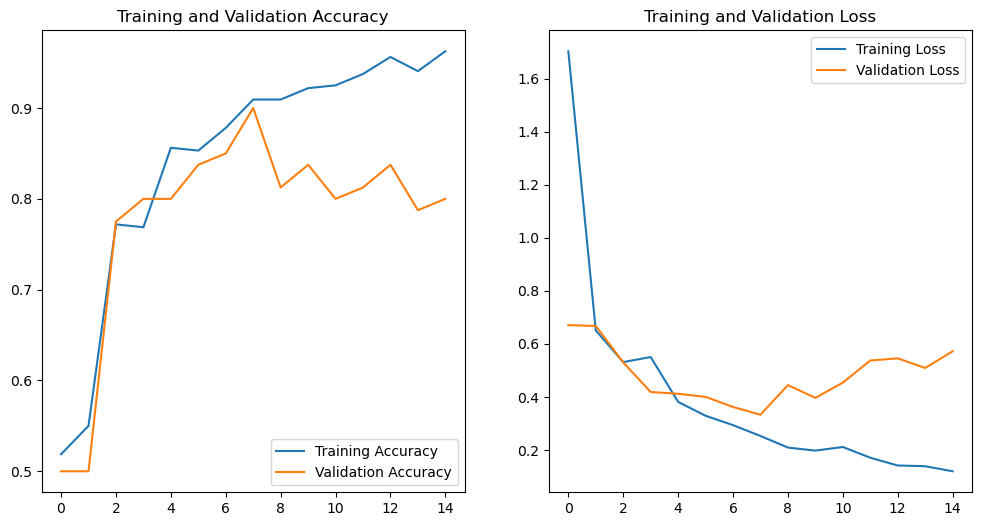

In [45]:
if __name__ == "__main__":
    # 1. Load Data
    X, y = load_data(IMAGE_DIR, IMAGE_SIZE)
    
    # 2. Encode Labels
    # Convert string labels ("dandelion", "grass") to numbers (0, 1)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)
    
    print(f"Found {num_classes} classes: {label_encoder.classes_}")
    
    # 3. Split Data
    print(f"Splitting data: {1-TEST_SPLIT_SIZE:.0%} train, {TEST_SPLIT_SIZE:.0%} validation...")
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_encoded, 
        test_size=TEST_SPLIT_SIZE, 
        random_state=RANDOM_SEED,
        stratify=y_encoded # Ensures balanced classes in splits
    )
    
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    
    # 4. Build Model
    input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    model = build_model(input_shape, num_classes)
    
    # 5. Compile Model
    if num_classes == 2:
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    else:
         model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
    model.summary()
    
    # 6. Train Model
    print("\nStarting model training...")
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val)
    )
    print("Training complete.")
    
    # 7. Evaluate and Save
    val_loss, val_acc = model.evaluate(X_val, y_val)
    print(f"\nFinal Validation Accuracy: {val_acc*100:.2f}%")
    
    # 8. Save Plot
    plot_history(history)
    
    # 9. Save Model
    model_filename = "dandelion_grass_cnn.keras"
    model.save(model_filename)
    print(f"Model saved to '{model_filename}'")